In [13]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack

In [14]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [15]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [17]:
from pre_processamento import pre_processamento

In [12]:
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/Datasets/train.tsv', sep = '\t')
test = pd.read_csv('/content/drive/MyDrive/Datasets/test.tsv', sep = '\t')

Mounted at /content/drive


In [18]:
train,test = pre_processamento(train,test)

In [27]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 
X = train.drop("price", axis = 1)
y = train["price"]

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.4, random_state=10) #Divisão em 80/20

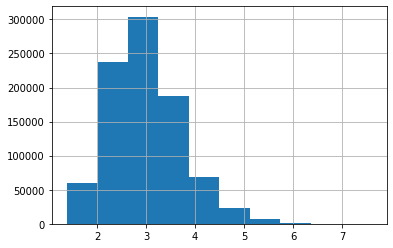

In [28]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
yval =  np.log1p(yval)
ytrain.hist()

In [29]:
Xtrain.head()

,name,item_condition_id,brand_name,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
285664,Jandals,3,NaN,0,Good condition,1,Women,Shoes,Sandals,4.0,2018.0
685118,Donkey Kong Country 2 Nintendo Game Boy,3,NaN,1,Will work with Nintendo GameBoy Advance SP. Ni...,3,Electronics,Video Games & Consoles,Consoles,8.0,2018.0
974069,NWT Mini hair straightener!,1,NaN,1,It's purple! Price includes half shipping Trav...,11,Beauty,Tools & Accessories,Hair Styling Tools,12.0,2018.0
778919,Sherri Hill prom dress,2,Sherri Hill,1,"Paid over [rm], asking [rm] (willing to negoti...",10,Women,Dresses,Full-Length,5.0,2018.0
1092378,Cardigan Bundle,3,Gap,0,"Two medium cardigans, both size mediums. One f...",17,Women,Sweaters,Cardigan,5.0,2018.0


In [30]:
Xval.head()

,name,item_condition_id,brand_name,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
20170,Swiss Army knife,1,NaN,1,New in original box. Never used.,13,Sports & Outdoors,Outdoors,Hiking & Camping,4.0,2018.0
155565,Dove Soap Mega LOT Assorted,1,Dove,0,(9) 4ct (36 bars total) Dove Soap (5) Febreze ...,1,Other,Daily & Travel items,Personal Care,6.0,2018.0
142735,"LOWEST PRICE, HIGHEST QUALITY BLENDER",1,NaN,1,STOP THROWING YOUR MAKEUP AWAY ! ! * ~ * Newes...,7,Beauty,Tools & Accessories,Makeup Brushes & Tools,1.0,2018.0
709876,Gold aluminum fidget spinner,1,NaN,1,Aluminum fidget spinner: Brand new . Comes in ...,13,Kids,Toys,Games,5.0,2018.0
723286,Duffle bag,3,NaN,0,Used duffle bag Perfect for young girls for tr...,43,Women,Women's Handbags,Totes & Shoppers,2.0,2018.0


#   Pré-processamento

In [31]:
#Função para "separação" de palavras, ex: Can't -> can not, objetivo de facilitar a limpeza, aonde não serão criadas duas palavras para cant/can not.
# Será feito para diversas palavras com a mesma condição.

def text_preprocess(phrase):
    
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    phrase = re.sub('https?://\S+| www.\S+', '', phrase) #Remoção de qualquer site que possa ter no nosso dataset
    phrase = re.sub("[^a-zA-Z0-9' \n\.]", '', phrase)  #excluindo tudo o que não for letra e numero.
    
    phrase = re.sub(' +', ' ', phrase) #exclusão de espaços extras, ex: "eu    vou" -> "eu vou"

    phrase = phrase.lower() #passando para letra minúscula.

   
    return phrase

In [32]:
Xtrain["name"] = Xtrain["name"].apply(lambda x: text_preprocess(x))

In [33]:
Xtrain["item_description"] = Xtrain["item_description"].astype(str)

In [34]:
Xtrain["item_description"] = Xtrain["item_description"].apply(lambda x: text_preprocess(x))

In [35]:
Xtrain

,name,item_condition_id,brand_name,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
285664,jandals,3,NaN,0,good condition,1,Women,Shoes,Sandals,4.0,2018.0
685118,donkey kong country 2 nintendo game boy,3,NaN,1,will work with nintendo gameboy advance sp. ni...,3,Electronics,Video Games & Consoles,Consoles,8.0,2018.0
974069,nwt mini hair straightener,1,NaN,1,it is purple price includes half shipping trav...,11,Beauty,Tools & Accessories,Hair Styling Tools,12.0,2018.0
778919,sherri hill prom dress,2,Sherri Hill,1,paid over rm asking rm willing to negotiate si...,10,Women,Dresses,Full-Length,5.0,2018.0
1092378,cardigan bundle,3,Gap,0,two medium cardigans both size mediums. one fr...,17,Women,Sweaters,Cardigan,5.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...
1349096,drifit style leggings,2,No Boundaries,0,no description yet,19,Women,Athletic Apparel,"Pants, Tights, Leggings",11.0,2018.0
1154832,bundle for bonnie,2,Mossimo,0,size 4. beautiful dress with stretchy fabric t...,3,Women,Dresses,Knee-Length,10.0,2018.0
618168,jordan 6 retro is,2,NaN,0,item for sale jordan 6 retro is size 10c condi...,4,Kids,Boys 2T-5T,Shoes,12.0,2018.0
1049143,vintage victoria is secret slip,3,Victoria's Secret,0,vintage gold tag victoria is secret lingerie s...,1,Women,Tops & Blouses,"Tank, Cami",6.0,2018.0


In [40]:
vec_name = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df = 50) #vetorização, com stop word. 
vec_desc = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df = 50) #vetorização, com stop word. 

vce_xtrain_name = vec_name.fit_transform(Xtrain["name"])
vce_xtrain_descrip = vec_desc.fit_transform(Xtrain["item_description"])

In [41]:
vce_xtrain_descrip

<888996x39930 sparse matrix of type '<class 'numpy.float64'>'
	with 17587568 stored elements in Compressed Sparse Row format>

In [42]:
ohe = OneHotEncoder(handle_unknown="ignore")

#aplicação dummy nas colunas categóricas.

ohe_condition = ohe.fit_transform(Xtrain[["item_condition_id",   
                                         "shipping",
                                         "brand_name",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                         "datetime_month"]])

In [43]:
ohe_condition

<888996x5177 sparse matrix of type '<class 'numpy.float64'>'
	with 6222972 stored elements in Compressed Sparse Row format>

In [44]:
#juntando cada matrix gerada por cada pré-processamento
from sklearn.decomposition import TruncatedSVD

x_train = hstack([(ohe_condition), (vce_xtrain_name), (vce_xtrain_descrip)])

svd = TruncatedSVD(n_components=100, algorithm = 'arpack', tol=0.1)

x_train_pca = svd.fit_transform(x_train)
x_train_pca

array([[ 1.62442960e+00, -9.10209507e-01,  5.62755761e-02, ...,
         9.84411267e-04,  1.57342688e-02, -1.26034833e-02],
       [ 1.11343382e+00,  5.74376333e-01,  3.13792360e-01, ...,
        -5.09888620e-03, -6.48935671e-02, -5.42784093e-03],
       [ 1.27952207e+00,  1.32367342e+00, -3.61661182e-01, ...,
        -5.30189949e-03,  2.20262815e-02, -1.32043341e-02],
       ...,
       [ 1.18222970e+00, -4.84398829e-01, -5.68764875e-01, ...,
         2.27077204e-02,  1.15062172e-01,  3.70706354e-02],
       [ 1.26828866e+00, -1.12311098e+00,  3.81476400e-01, ...,
        -5.85960079e-03, -1.67390772e-04, -2.97568100e-02],
       [ 7.52920717e-01,  2.63368546e-01,  5.33019622e-01, ...,
        -1.14776636e-02, -1.28680347e-03,  2.23340734e-02]])

In [45]:
lr = LinearRegression()

model = lr.fit(x_train_pca, ytrain)

In [46]:
Xval["name"] = Xval["name"].apply(lambda x: text_preprocess(x))
Xval["item_description"] = Xval["item_description"].astype(str)
Xval["item_description"] = Xval["item_description"].apply(lambda x: text_preprocess(x))

vce_xval_name = vec_name.transform(Xval["name"])
vce_xval_descrip = vec_desc.transform(Xval["item_description"])

ohe_val_condition = ohe.transform(Xval[["item_condition_id",   
                                          "shipping",
                                          "brand_name",
                                          "gen_cat",
                                          "sub1_cat",
                                          "sub2_cat", 
                                          "datetime_month"]])

x_val = hstack([(vce_xval_name), (vce_xval_descrip), (ohe_val_condition)])

In [47]:
import math
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

x_val_pca = svd.transform(x_val)

y_true = [math.exp(i)-1 for i in model.predict(x_val_pca)]
print(mean_absolute_error(yval,y_true))
print(mean_squared_error(yval,y_true))
print(mean_squared_log_error(yval,y_true))

7.017428169041546
49.86225365997579
1.101374676532626
